In [63]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [122]:
import sys
sys.path.append("..")
import grading
grader = grading.Grader(assignment_key="UaHtvpEFEee0XQ6wjK-hZg", 
                      all_parts=["xU7U4", "HyTF6", "uNidL", "ToK7N", "GBdgZ", "dLdHG"])

In [162]:
# token expires every 30 min
COURSERA_TOKEN = 'ebsGlk99cmKTQrTt' ### YOUR TOKEN HERE
COURSERA_EMAIL = 'idin.consulting@gmail.com' ### YOUR EMAIL HERE

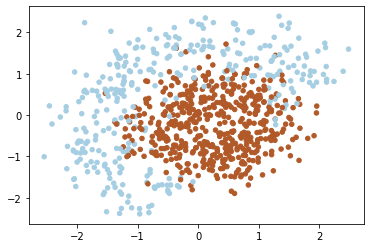

In [64]:
with open('train.npy', 'rb') as train:
    X = np.load(train)

with open('target.npy', 'rb') as target:
    y = np.load(target)

plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

In [83]:
print("Feature matrix size: ", X.shape)
print("Target size: ", y.shape)

Feature matrix size:  (826, 2)
Target size:  (826,)


In [69]:
def expand(X):
    '''Adds quadratic features.
    
    For each sample(row in matrix), computes an extended row:
    [f0,f1,f0^2,f1^2,f0*f1,1]

    Args:
    X (np.array): matrix of features in a form of a numpy list. [n_samples,2]

    Returens:
    X (np.array): expanded features in the form of a numpy list. [n_samples, 6]
    '''

    X_expanded = np.zeros((X.shape[0],6))

    X_expanded[:,0] = X[:,0]
    X_expanded[:,1] = X[:,1]
    X_expanded[:,2] = X[:,0] ** 2
    X_expanded[:,3] = X[:,1] ** 2
    X_expanded[:,4] = X[:,0] * X[:,1]
    X_expanded[:,5] = 1

    return X_expanded

In [71]:
X_expanded = expand(X)

In [74]:
# simple test on random numbers

dummy_X = np.array([
        [0,0],
        [1,0],
        [2.61,-1.28],
        [-0.59,2.1]
    ])

# call your expand function
dummy_expanded = expand(dummy_X)

# what it should have returned:   x0       x1       x0^2     x1^2     x0*x1    1
dummy_expanded_ans = np.array([[ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ],
                               [ 1.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ],
                               [ 2.61  , -1.28  ,  6.8121,  1.6384, -3.3408,  1.    ],
                               [-0.59  ,  2.1   ,  0.3481,  4.41  , -1.239 ,  1.    ]])

#tests
assert isinstance(dummy_expanded,np.ndarray), "please make sure you return numpy array"
assert dummy_expanded.shape == dummy_expanded_ans.shape, "please make sure your shape is correct"
assert np.allclose(dummy_expanded,dummy_expanded_ans,1e-3), "Something's out of order with features"

print("Seems legit!")

Seems legit!


## Logistic regression

To classify objects we will obtain probability of object belongs to class '1'. To predict probability we will use output of linear model and logistic function:

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [116]:
def probability(X, w):
    ''' Given input features and weights return predicted probabilities of y==1 given x, P(y=1|x)

    Args:
        X (np.ndarray): feature matrix X (use X_expanded if necessary); [n_samples, 6]
        w (np.ndarray): wight vector w for each of the expanded features; [6,1]
    
    Returns:
        sig (np.ndarray): an array of predicted probabilities in [0,1] interval.
    '''

    a = X.dot(w)
    sig = 1/(1+np.exp(-1*a))
    return sig

In [142]:
dummy_weights = np.linspace(-1, 1, 6)
ans_part1 = probability(X_expanded[:1, :], dummy_weights)[0]
print("Positive class probability for the first example: {:.2f}".format(ans_part1))

Positive class probability for the first example: 0.38


In logistic regression the optimal parameters $w$ are found by cross-entropy minimization:

Loss for one sample: $$ l(x_i, y_i, w) = - \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1\, | \, x_i,w))}\right] $$

Loss for many samples: $$ L(X, \vec{y}, w) =  {1 \over \ell} \sum_{i=1}^\ell l(x_i, y_i, w) $$



In [152]:
def compute_loss(X, y, w):
    ''' Given the dataset computes the binary cross-entropy loss function
    
    Args:
        X (np.ndarray): feature matrix X (use X_expanded if necessary); [n_samples, 6]
        w (np.ndarray): wight vector w for each of the expanded features; [6,1]
        y (np.ndarray): target values for each sample; [n_sample, 1]
    
    Returns:
        L (float): Loss value for provided w parameters
    
    '''
    sig = probability(X,w)
    L = (1/X.shape[0]) * sum(-1 * (y * np.log(sig)+(1-y) * np.log(1-sig)))
    
    return L

In [156]:
# use output of this cell to fill answer field 
ans_part2 = compute_loss(X_expanded, y, dummy_weights)
print("Loss value for the current dummy_weights: ", ans_part2)

Loss value for the current dummy_weights:  1.0185634030782509


Since we train our model with gradient descent, we should compute gradients.

To be specific, we need a derivative of loss function over each weight [6 of them].

$$ \nabla_w L = {1 \over \ell} \sum_{i=1}^\ell \nabla_w l(x_i, y_i, w) $$ 

We won't be giving you the exact formula this time — instead, try figuring out a derivative with pen and paper. 

As usual, we've made a small test for you, but if you need more, feel free to check your math against finite differences (estimate how $L$ changes if you shift $w$ by $10^{-5}$ or so).



$$ \frac{\partial L(w)}{\partial w} = \frac{1}{l} X^T [P(Xw) - y] $$

In [211]:
def compute_grad(X, y, w):
    ''' Given the dataset computes derivative vector [6] of L over each weights.

    Args:
        X (np.ndarray): feature matrix X (use X_expanded if necessary); [n_samples, 6]
        w (np.ndarray): wight vector w for each of the expanded features; [6,1]
        y (np.ndarray): target values for each sample; [n_sample, 1]
    
    Returns:
        w_grad (np.ndarray): derivative vector [6] of L over each weights: [6,1]
    '''

    w_grad = 1/X.shape[0] * np.transpose(X).dot(probability(X, w) - y)

    return w_grad

In [212]:
# use output of this cell to fill answer field 
ans_part3 = np.linalg.norm(compute_grad(X_expanded, y, dummy_weights))

[-0.32741296  0.05429288  0.31961242  0.38946883  0.2029897   0.06801579]


In [213]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("uNidL", ans_part3)

In [214]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
